In [2]:
#Bootstrapping
import pandas as pd
import numpy as np

df=pd.read_csv('/home/dherya.malhotra/Carpe_DM/PAPER_CODES/MBZUAI_POC_PAPER_DATA - Sheet1.csv')
df=df[df['Stock market return (%, year-on-year)(Y)']!=0]
df = df[df['Oil Export Price (X)($/Barrel)'].notna()]
df[df['Country']=='UAE']

,Country,Crude Grade,Year,Oil Export Price (X)($/Barrel),"Stock market return (%, year-on-year)(Y)",GDP per Capita (Constant 2015 US$)(Z),Political Risk Index(Z)($)
11,UAE,Murban,2011,109.77,14.823190,43800.15930,0.912176
12,UAE,Murban,2012,111.76,-6.251017,42868.09750,0.863251
13,UAE,Murban,2013,108.21,-6.519889,43269.84047,0.894792
14,UAE,Murban,2014,99.45,4.275693,43023.19042,0.768909
15,UAE,Murban,2015,53.87,0.309401,43534.99727,0.748049
16,UAE,Murban,2016,44.83,1.552132,43745.28817,0.549646
17,UAE,Murban,2017,54.82,8.972898,42690.21478,0.601950
18,UAE,Murban,2018,72.20,2.061658,42679.75191,0.689256
19,UAE,Murban,2019,64.72,-13.216550,42700.12979,0.667538
20,UAE,Murban,2020,42.98,24.706250,40776.63087,0.592605


In [3]:
A=df[["Oil Export Price (X)($/Barrel)","Stock market return (%, year-on-year)(Y)","GDP per Capita (Constant 2015 US$)(Z)","Political Risk Index(Z)($)"]]
A.shape


(110, 4)

In [4]:

def Bootstrap(A):
    r=A.shape[0]
    c=A.shape[1]
    ans=pd.DataFrame(columns=A.columns)
    for i in range(r):
        temp=np.random.randint(0,r)
        ans.loc[len(ans)]=A.iloc[temp]
    return ans

In [5]:
A.describe()

,Oil Export Price (X)($/Barrel),"Stock market return (%, year-on-year)(Y)",GDP per Capita (Constant 2015 US$)(Z),Political Risk Index(Z)($)
count,110.000000,110.000000,110.000000,110.000000
mean,75.480000,5.277444,26645.732451,-0.131715
std,26.346041,14.255645,22081.953152,0.857444
min,36.610000,-25.475430,2337.575874,-2.130276
25%,52.072500,-5.144300,9514.342969,-0.662088
50%,69.690000,4.734946,19562.030800,0.084026
75%,105.130000,11.584178,42826.105573,0.596330
max,117.150000,54.041000,81608.571690,1.223599


In [6]:
def erf_asy(x):
    # coefficients
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    p = 0.3275911

    sign = np.sign(x)  # Element-wise sign function
    x = np.abs(x)
    t = 1 / (1 + p * x)
    y = 1 - (((((a5 * t + a4) * t + a3) * t + a2) * t + a1) * t * np.exp(-x * x))
    return sign * y



In [7]:

import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm


from scipy.integrate import quad



def PNS_Y0_Bootstrap_CI(A, iter, rho, alpha, y,y_,a,b,c1,c2):
    if(y_<y):
        n = A.shape[0]
        PNS_Y0_estimate = []
        threshold=[]
        for j in range(iter):
            B = Bootstrap(A)  
            II_y = (B['Stock market return (%, year-on-year)(Y)'] < y).astype(int)
            II_y_= (B['Stock market return (%, year-on-year)(Y)'] < y_).astype(int)

            X = np.array(B['Oil Export Price (X)($/Barrel)']).reshape(-1, 1)
            C1 = np.array(B['GDP per Capita (Constant 2015 US$)(Z)']).reshape(-1, 1)
            C2 = np.array(B['Political Risk Index(Z)($)']).reshape(-1, 1)
            clf = LogisticRegression(max_iter=500)
            clf.fit(np.hstack([X, C1, C2]), II_y)
            clf_1 = LogisticRegression(max_iter=500)
            clf_1.fit(np.hstack([X, C1, C2]), II_y_)
            P0 = clf_1.predict_proba(np.array([[a,c1,c2]]))[:, 1]
            P1 = clf.predict_proba(np.array([[b,c1,c2]]))[:, 1]
            C = norm.ppf(P0)
            D = norm.ppf(P1)
            threshold_B=C/D
            threshold.append(threshold_B)
            temp=(D-rho*C)/np.sqrt(2*(1-rho**2))
            PNS_Y0_estimate_B = 0.5*(1-erf_asy(temp))
            PNS_Y0_estimate.append(PNS_Y0_estimate_B)
        threshold=np.array(threshold)
        PNS_Y0_estimate = np.array(PNS_Y0_estimate)
        lower = np.percentile(PNS_Y0_estimate, alpha)
        upper = np.percentile(PNS_Y0_estimate, 100 - alpha)
        mean = np.mean(PNS_Y0_estimate)
        lower_thr=np.percentile(threshold,alpha)
        upper_thr=np.percentile(threshold,100-alpha)
        mean_thr=np.mean(threshold)
        return np.array([lower, mean, upper,lower_thr,mean_thr,upper_thr])
    else:
        return np.array([0,0,0,0,0,0])


In [8]:
rhos=np.linspace(-0.99,0.99,20)

row = df[(df['Country'] == 'UAE') & (df['Year'] == 2014)].iloc[0]

y_ = float(row['Stock market return (%, year-on-year)(Y)'])
a = float(row['Oil Export Price (X)($/Barrel)'])
c1=float(row['GDP per Capita (Constant 2015 US$)(Z)'])
c2=float(row['Political Risk Index(Z)($)'])

In [9]:
temp=PNS_Y0_Bootstrap_CI(A,100,-0.99,2.5,8,y_,a,80,c1,c2)
print(temp)

[ 9.28830357e-03  8.09017948e-01  1.00000000e+00 -1.15552645e+01
 -6.32340090e+00  1.09813663e+01]


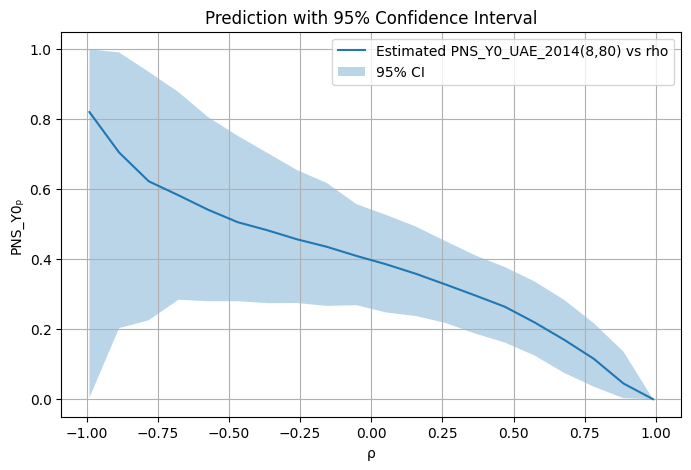

In [21]:
PNS_Y0_estimate_rhos_l=[]
PNS_Y0_estimate_rhos_m=[]
PNS_Y0_estimate_rhos_u=[]
thr_lower_rhos=[]
thr_mean_rhos=[]
thr_upper_rhos=[]
b=80
y=8
for r in rhos:
    temp=PNS_Y0_Bootstrap_CI(A,1000,r,2.5,y,y_,a,b,c1,c2)
    PNS_Y0_estimate_rhos_l.append(temp[0])
    PNS_Y0_estimate_rhos_m.append(temp[1])
    PNS_Y0_estimate_rhos_u.append(temp[2])
    thr_lower_rhos.append(temp[3])
    thr_mean_rhos.append(temp[4])
    thr_upper_rhos.append(temp[5])
thr_lower=np.mean(thr_lower_rhos)
thr_mean=np.mean(thr_mean_rhos)
thr_upper=np.mean(thr_upper_rhos)
PNS_Y0_mean = np.array(PNS_Y0_estimate_rhos_m)
PNS_Y0_lower = np.array(PNS_Y0_estimate_rhos_l)
PNS_Y0_upper = np.array(PNS_Y0_estimate_rhos_u)


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(rhos, PNS_Y0_mean, label=f'Estimated PNS_Y0_UAE_2014({y},{b}) vs rho')
plt.fill_between(rhos, PNS_Y0_lower, PNS_Y0_upper, alpha=0.3, label='95% CI')
plt.xlabel("ρ")
plt.ylabel("PNS_Y0ₚ")
plt.title("Prediction with 95% Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

In [12]:

print(PNS_Y0_mean.max(),PNS_Y0_mean.min())

0.7858659408191774 6.263397266185744e-06


In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm


from scipy.integrate import quad



def PNS_Y1_Bootstrap_CI(A, iter, rho, alpha, y,y_,a,b,c1,c2):
    if(y_>y):
        n = A.shape[0]
        PNS_Y1_estimate = []
        threshold=[]
        for j in range(iter):
            B = Bootstrap(A) 
            II_y = (B['Stock market return (%, year-on-year)(Y)'] < y).astype(int)
            II_y_= (B['Stock market return (%, year-on-year)(Y)'] < y_).astype(int)

            X = np.array(B['Oil Export Price (X)($/Barrel)']).reshape(-1, 1)
            C1 = np.array(B['GDP per Capita (Constant 2015 US$)(Z)']).reshape(-1, 1)
            C2 = np.array(B['Political Risk Index(Z)($)']).reshape(-1, 1)
            clf = LogisticRegression(max_iter=500)
            clf.fit(np.hstack([X, C1, C2]), II_y)
            clf_1 = LogisticRegression(max_iter=500)
            clf_1.fit(np.hstack([X, C1, C2]), II_y_)
            P0 = clf.predict_proba(np.array([[a,c1,c2]]))[:, 1]
            P1 = clf_1.predict_proba(np.array([[b,c1,c2]]))[:, 1]
            threshold_B=P0/P1
            threshold.append(threshold_B)
            C = norm.ppf(P0)
            D = norm.ppf(P1)
            temp=(C-rho*D)/np.sqrt(2*(1-rho**2))
            PNS_Y1_estimate_B = 0.5*(1+erf_asy(temp))
            PNS_Y1_estimate.append(PNS_Y1_estimate_B)
        threshold=np.array(threshold)
        PNS_Y1_estimate = np.array(PNS_Y1_estimate)
        lower = np.percentile(PNS_Y1_estimate, alpha)
        upper = np.percentile(PNS_Y1_estimate, 100 - alpha)
        mean = np.mean(PNS_Y1_estimate)
        lower_thr=np.percentile(threshold,alpha)
        upper_thr=np.percentile(threshold,100-alpha)
        mean_thr=np.mean(threshold)
        return np.array([lower, mean, upper,lower_thr,mean_thr,upper_thr])
    else:
        return np.array([0,0,0,0,0,0])


In [14]:
temp=PNS_Y1_Bootstrap_CI(A,100,-0.999,2.5,0,y_,80,a,c1,c2)
print(temp)

[0.00000000e+00 1.05537084e-02 1.35974593e-06 8.41979422e-01
 1.22643904e+00 1.83286514e+00]


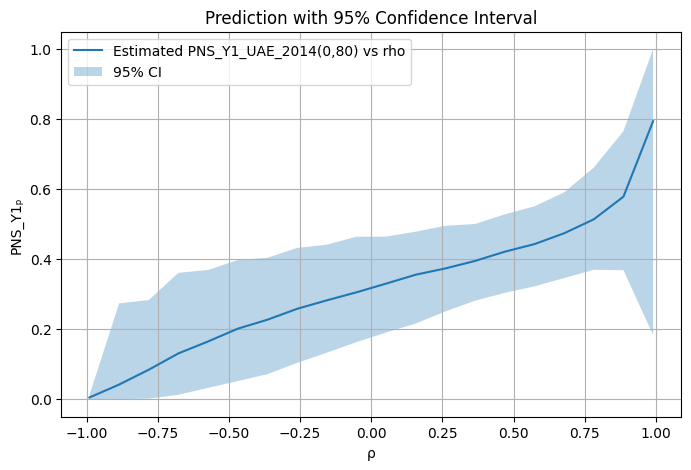

In [22]:
PNS_Y1_estimate_rhos_l=[]
PNS_Y1_estimate_rhos_m=[]
PNS_Y1_estimate_rhos_u=[]
thr_lower_rhos=[]
thr_mean_rhos=[]
thr_upper_rhos=[]
y=0
b=80
for r in rhos:
    temp=PNS_Y1_Bootstrap_CI(A,1000,r,2.5,y,y_,b,a,c1,c2)
    PNS_Y1_estimate_rhos_l.append(temp[0])
    PNS_Y1_estimate_rhos_m.append(temp[1])
    PNS_Y1_estimate_rhos_u.append(temp[2])
    thr_lower_rhos.append(temp[3])
    thr_mean_rhos.append(temp[4])
    thr_upper_rhos.append(temp[5])
thr_lower=np.mean(thr_lower_rhos)
thr_mean=np.mean(thr_mean_rhos)
thr_upper=np.mean(thr_upper_rhos)
PNS_Y1_mean = np.array(PNS_Y1_estimate_rhos_m)
PNS_Y1_lower = np.array(PNS_Y1_estimate_rhos_l)
PNS_Y1_upper = np.array(PNS_Y1_estimate_rhos_u)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(rhos, PNS_Y1_mean, label=f'Estimated PNS_Y1_UAE_2014({y},{b}) vs rho')
plt.fill_between(rhos, PNS_Y1_lower, PNS_Y1_upper, alpha=0.3, label='95% CI')
plt.xlabel("ρ")
plt.ylabel("PNS_Y1ₚ")
plt.title("Prediction with 95% Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print(PNS_Y1_mean.max(),PNS_Y1_mean.min())

0.7670557358425693 0.004463230180153535


In [20]:
print(PNS_Y1_Bootstrap_CI(A,100,-0.999,2.5,0,y_,120,a,c1,c2))

[0.00000000e+00 3.33622019e-16 0.00000000e+00 3.24018858e-01
 5.97085742e-01 8.54992671e-01]
